# 最適フィードバック制御モデル
ToDo: infiniteOFCと数式の統一を行う．

## 最適フィードバック制御モデルの構造
**最適フィードバック制御モデル (optimal feedback control; OFC)** の特徴として目標軌道を必要としないことが挙げられる．**Kalman フィルタ**による状態推定と**線形2次レギュレーター(LQR: linear-quadratic regurator)** により推定された状態に基づいて運動指令を生成という2つの流れが基本となる．

### 系の状態変化

$$
\begin{align}
&\text {Dynamics} \quad \mathbf{x}_{t+1}=A \mathbf{x}_{t}+B \mathbf{u}_{t}+\boldsymbol{\xi}_{t}+\sum_{i=1}^{c} \varepsilon_{t}^{i} C_{i} \mathbf{u}_{t}\\
&\text {Feedback} \quad \mathbf{y}_{t}=H \mathbf{x}_{t}+\omega_{t}+\sum_{i=1}^{d} \epsilon_{t}^{i} D_{i} \mathbf{x}_{t}\\
&\text{Cost per step}\quad \mathbf{x}_{t}^\top Q_{t} \mathbf{x}_{t}+\mathbf{u}_{t}^\top R \mathbf{u}_{t}
\end{align}
$$

### LQG
加法ノイズしかない場合($C=D=0$)，制御問題は**線形2次ガウシアン(LQG: linear-quadratic-Gaussian)制御**と呼ばれる．


#### 運動制御 (Linear-Quadratic Regulator)

$$
\begin{align}
\mathbf{u}_{t}&=-L_{t} \widehat{\mathbf{x}}_{t}\\
L_{t}&=\left(R+B^{\top} S_{t+1} B\right)^{-1} B^{\top} S_{t+1} A\\
S_{t}&=Q_{t}+A^{\top} S_{t+1}\left(A-B L_{t}\right)\\
s_t &= \mathrm{tr}(S_{t+1}\Omega^\xi) + s_{t+1}; s_T=0
\end{align}
$$

$\boldsymbol{S}_{T}=Q$

#### 状態推定 (Kalman Filter)

$$
\begin{align}
\widehat{\mathbf{x}}_{t+1}&=A \widehat{\mathbf{x}}_{t}+B \mathbf{u}_{t}+K_{t}\left(\mathbf{y}_{t}-H \widehat{\mathbf{x}}_{t}\right)+\boldsymbol{\eta}_{t} \\ 
K_{t}&=A \Sigma_{t} H^{\top}\left(H \Sigma_{t} H^{\top}+\Omega^{\omega}\right)^{-1} \\ 
\Sigma_{t+1}&=\Omega^{\xi}+\left(A-K_{t} H\right) \Sigma_{t} A^{\top}
\end{align}
$$

この場合に限り，運動制御と状態推定を独立させることができる．

### 一般化LQG
状態および制御依存ノイズがある場合，

## 実装
ライブラリの読み込みと関数の定義．

状態変数 $x \in \mathbb{R}^n$, 制御変数 $u \in \mathbb{R}^m$, 観測変数 $y \in \mathbb{R}^p$

$A \in \mathbb{R}^{n\times n}, B \in \mathbb{R}^{n\times m}, C \in \mathbb{R}^{p\times n}$

$$
\begin{align}
dx/dt=Ax+Bu + v\\
dy/dt=Cx + w
\end{align}
$$

- 関数内に無駄が多いので，引数を削る．複数の次元で対応可能にする．
- noisyを追加する．
- structは1つでいいのでは
- X1はsimulationの際に与える．

In [1]:
using Base: @kwdef
using Parameters: @unpack
using LinearAlgebra, Kronecker, Random, ToeplitzMatrices, BlockDiagonals, PyPlot
rc("axes.spines", top=false, right=false)
rc("font", family="Arial") 

In [ ]:
struct ControlSystem
    A::Array # (n, n)
    B::Array # (n, m)
    C::Array # (p, n)
    
    Σv::Array # covariance of state noise, (n, n)
    Σw::Array # covariance of observed noise, (p, p)

    Q::Array # x-dependent cost param. 
    R::Array # u-dependent cost param.
    U::Array # x_bar-dependent cost param.
    
    Σ₁::Array # initial covariance
    nt::Int
end

In [2]:
@kwdef struct Reaching2DModelParameter
    dt = 1.0  # 10 msec
    n = 6
    p = 6
    A = diagm(2 => ones(4))
    B = [zeros(4, 2); I]
    C = I(n)
    D = 1e-4 * diagm([1, 1, .1, .1, .01, .01])
    G = D
    # V to D, W to G
end

@kwdef mutable struct Reaching2DModelCostParameter
    n = 6 # p_x, p_y, v_x, v_y, a_x, a_y
    T = 111
    dt = 1.0
    q = 200
    nt = round(Int, T/dt) # num time steps
    #Q = [zeros(nt-1, n, n); reshape((1e-5 * diagm([1, 1, q, q, 0, 0])), (1, n, n))]
    Q = 1e-5 * diagm([1, 1, q, q, 0, 0])
    R = I(2)
    init_pos = [5, 5]
    x₁ = [init_pos; zeros(n-2)]  # [cm]
    Σ₁ = zeros(n, n)
end

Reaching2DModelCostParameter

Neural OFC論文ではLとKが入れ替わっている．

In [13]:
function LQG(param, cost_param; discrete=true)
    (;n, p, A, B, C, D, G) = param
    (;Q, R, x₁, Σ₁, dt, nt) = cost_param
    
    L = zeros(nt-1, n, 2) # Feedback gains
    K = zeros(nt-1, n, p) # Kalman gains
    S = Q # S_T = Q
    #S = Q[end, :, :] # S_T = Q
    #S = copy(Q[end, :, :]) # S_T = Q
    Σ = copy(Σ₁);

    if discrete
        A = I + A * dt
        B = B * dt
        C = C * dt
        D = sqrt(dt) * D
        G = sqrt(dt) * G
    end

    # Ricatti equations
    for t in 1:nt-1
        K[t, :, :] = A * Σ * C' / (C * Σ * C' + D) # update K
        Σ = G + (A - K[t, :, :] * C) * Σ * A'      # update Σ
    end　
    
    cost = 0
    for t in nt-1:-1:1
        cost += tr(S * G)
        L[t, :, :] = ((R + B' * S * B) \ B' * S * A)' # update L
        S = Q + A' * S * (A - B * L[t, :, :]')     # update S
        #S = Q[t, :, :] + A' * S * (A - B * L[t, :, :]')     # update S
    end
    
    # adjust cost
    cost += x₁' * S * x₁
    return L, K, cost
end

LQG (generic function with 1 method)

In [4]:
param = Reaching2DModelParameter()
cost_param = Reaching2DModelCostParameter();

In [14]:
L, K, cost = LQG(param, cost_param);

In [15]:
function simulation(param, cost_param, 
                    L, K; noisy=false)
    @unpack n, p, A, B, C, D, G = param
    @unpack Q, R, x₁, dt, nt = cost_param
    
    X = zeros(n, nt)
    u = zeros(nt, 2)
    X[:, 1] = x₁ # m; initial position (target position is zero)
    
    for t in 1:nt-1
        u[t, :] = -L[t, :, :]' * X[:, t]
        X[:, t+1] = X[:, t] + (A * X[:, t] + B * u[t, :]) * dt
    end
    return X, u
end

simulation (generic function with 1 method)

In [16]:
Xs = []
for i = 1:8
    alpha = i*pi/4
    init_pos = 10 * [cos(alpha), sin(alpha)]
    cost_param = Reaching2DModelCostParameter(init_pos=init_pos);
    X, u = simulation(param, cost_param, L, K)
    X[1, :] .-= init_pos[1]
    X[2, :] .-= init_pos[2]
    push!(Xs, X)
end

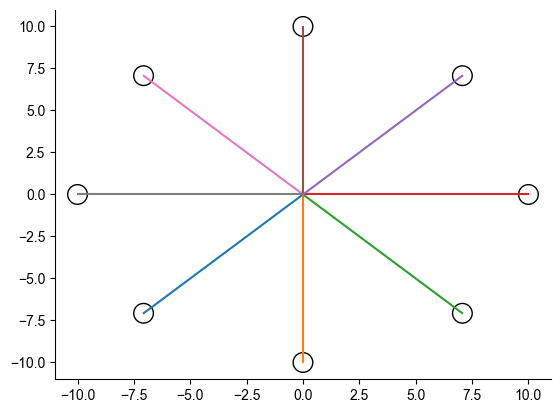

In [22]:
for i = 1:8
    alpha = i*pi/4
    init_pos = 10 * [cos(alpha), sin(alpha)]
    scatter(init_pos[1], init_pos[2], marker="o", fc="none", ec="k", s=200)
    plot(Xs[i][1, :], Xs[i][2, :])
end

In [9]:
A = param.A;
ΔA = zeros(6,6)
ΔA[3:4,3:4] = [-10.1 -11.2; -11.2 11.1]
A_force = A + 0.002*ΔA;

In [10]:
param_force = Reaching2DModelParameter(A=A_force)

Reaching2DModelParameter(1.0, 6, 6, [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0 0.0; 0.0 0.0; … ; 1.0 0.0; 0.0 1.0], Bool[1 0 … 0 0; 0 1 … 0 0; … ; 0 0 … 1 0; 0 0 … 0 1], [0.0001 0.0 … 0.0 0.0; 0.0 0.0001 … 0.0 0.0; … ; 0.0 0.0 … 1.0000000000000002e-6 0.0; 0.0 0.0 … 0.0 1.0000000000000002e-6], [0.0001 0.0 … 0.0 0.0; 0.0 0.0001 … 0.0 0.0; … ; 0.0 0.0 … 1.0000000000000002e-6 0.0; 0.0 0.0 … 0.0 1.0000000000000002e-6])

In [18]:
Xs_force = []
for i = 1:8
    alpha = i*pi/4
    init_pos = 10 * [cos(alpha), sin(alpha)]
    cost_param = Reaching2DModelCostParameter(init_pos=init_pos);
    X, u = simulation(param_force, cost_param, L, K)
    X[1, :] .-= init_pos[1]
    X[2, :] .-= init_pos[2]
    push!(Xs_force, X)
end

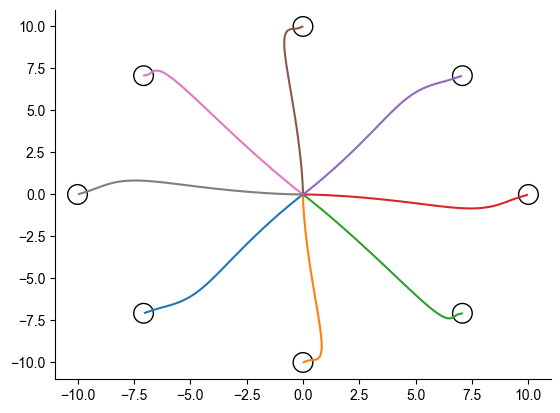

In [21]:
for i = 1:8
    alpha = i*pi/4
    init_pos = 10 * [cos(alpha), sin(alpha)]
    scatter(init_pos[1], init_pos[2], marker="o", fc="none", ec="k", s=200)
    plot(Xs_force[i][1, :], Xs_force[i][2, :])
end